## **Import Libraries**

In [1]:
!wget https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf -P /usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf


--2020-11-13 05:11:23--  https://github.com/Phonbopit/sarabun-webfont/raw/master/fonts/thsarabunnew-webfont.ttf
Resolving github.com (github.com)... 140.82.121.3
Connecting to github.com (github.com)|140.82.121.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf [following]
--2020-11-13 05:11:23--  https://raw.githubusercontent.com/Phonbopit/sarabun-webfont/master/fonts/thsarabunnew-webfont.ttf
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 98308 (96K) [application/octet-stream]
Saving to: ‘/usr/local/lib/python3.6/dist-packages/matplotlib/mpl-data/fonts/ttf/thsarabunnew-webfont.ttf’

thsarabunnew-webfon 100%[===================>]  96.00

In [2]:
from __future__ import absolute_import, division, print_function, unicode_literals

try: # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
%load_ext tensorboard
import datetime
import itertools
import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
matplotlib.font_manager._rebuild()
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import roc_auc_score

# NN specific imports:
import tensorflow as tf
# SVM imports:
from joblib import dump, load

# **Import Data**
Mount Drive folder to access data, make sure you run "Generate SASM signals.ipynb" first

In [3]:
from google.colab import drive
import pathlib
import os

drive.mount('/content/gdrive')
model_dir = '/content/gdrive/My Drive/Colab Notebooks/SASM/Models'
for modtype in ['/NN', '/SVM', '/LR']:
    os.makedirs(model_dir + modtype,exist_ok=True) # create folders necessary to store model

Mounted at /content/gdrive


In [4]:
def plot_cm(confusion):
    plt.figure(figsize=(12,12))
    plt.imshow(confusion, cmap='Blues')
    ax = plt.gca();
    # Minor ticks
    ax.set_xticks(np.arange(-0.5, num_keys, 8.5), minor=True);
    ax.set_yticks(np.arange(-0.5, num_keys, 8.5), minor=True);
    ax.set_xlabel('Predicted Label', fontname="Times", fontsize=24,fontweight='bold')
    ax.set_ylabel('Actual Label', fontname="Times", fontsize=24,fontweight='bold')
    # Gridlines based on minor ticks
    ax.grid(which='minor', color='silver', linestyle='-', linewidth=2)
    # New part
    # Normalize the confusion matrix.
    confusion = np.around(confusion.astype('float') / confusion.sum(axis=1)[:, np.newaxis], decimals=2)
    
    # Use white text if squares are dark; otherwise black.
    threshold = confusion.max() / 2.
 # Print the values on the confusion matrix   
 #   for i, j in itertools.product(range(confusion.shape[0]), range(confusion.shape[1])):
 #       color = "white" if confusion[i, j] > threshold else "black"
 #       plt.text(j, i, confusion[i, j], horizontalalignment="center", color=color, fontname="Times", fontsize=24)
    for tick in ax.xaxis.get_major_ticks():
        tick.label.set_fontsize(24) 
    for tick in ax.yaxis.get_major_ticks():
        tick.label.set_fontsize(24) 
        

Define path to data

In [5]:
!rm -rf ./logs/

In [7]:
#@title Set variables and load data
modulation_order =  2#@param {type:"raw"}
ifft_length = 64 #@param {type:"slider", min:32, max:128, step:1}
num_keys =  10#@param {type:"integer"}
train_samples = 250 #@param {type:"slider", min:10, max:1000, step:10}
exceeta =  32#@param {type:"integer"}
snr_db = 10 #@param {type:"integer"}
alpha =  0.2#@param {type:"number"}
print(num_keys)

ma = modulation_order
file_path = '/content/gdrive/My Drive/Colab Notebooks/SASM/Datasets'
os.makedirs(file_path,exist_ok=True) # create folders necessary to store data
data_dir = pathlib.Path(file_path)

# Previously its own cell
path = file_path + '/keys_' + str(num_keys) + '_snr_' + str(snr_db) + '_range_' + str(alpha) + '_exceeta_' + str(exceeta) + '_ifft_' + str(ifft_length) + '_samples_' + str(train_samples) + '.npz'
with np.load(path) as data:
  train_examples = data['x_train']
  train_labels = data['y_train']
  test_examples = data['x_test']
  test_labels = data['y_test']


NN_model_path = model_dir + '/NN/keys_' + str(num_keys) + '_snr_' + str(snr_db) + '_range_' + str(alpha) + '_exceeta_' + str(exceeta) + '_ifft_' + str(ifft_length) + '_samples_' + str(train_samples) + '.h5'
SVM_model_path = model_dir + '/SVM/keys_' + str(num_keys) + '_snr_' + str(snr_db) + '_range_' + str(alpha) + '_exceeta_' + str(exceeta) + '_ifft_' + str(ifft_length) + '_samples_' + str(train_samples) + '.joblib'
LR_model_path = model_dir + '/LR/keys_' + str(num_keys) + '_snr_' + str(snr_db) + '_range_' + str(alpha) + '_exceeta_' + str(exceeta) + '_ifft_' + str(ifft_length) + '_samples_' + str(train_samples) + '.joblib'

10


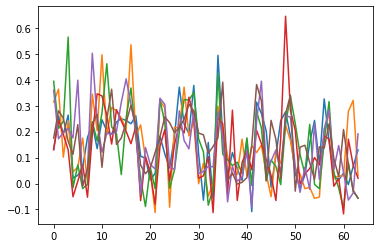

In [8]:
for _ in range(0, 501, 100):
  plt.plot(train_examples[_])

plt.show()

# **Neural Network**

In [9]:
#@title Set number of neurons in hidden layer
hidden_size = 50 #@param {type:"slider", min:1, max:128, step:1}

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_examples, train_labels))
test_dataset = tf.data.Dataset.from_tensor_slices((test_examples, test_labels))

BATCH_SIZE = 100
SHUFFLE_BUFFER_SIZE = 512

train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)
test_dataset = test_dataset.batch(BATCH_SIZE)

Create and compile

In [11]:
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(ifft_length, 1)),
    tf.keras.layers.Dense(hidden_size, activation='relu'),
    # tf.keras.layers.Dropout(.1),
    tf.keras.layers.Dense(num_keys, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.RMSprop(),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(),
                metrics=[tf.keras.metrics.SparseCategoricalAccuracy()])

# Previously its own cell
logs_base_dir = "./logs/fit"
log_dir = os.path.join(logs_base_dir, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1,embeddings_freq=1)

history=model.fit(train_dataset, 
          epochs=10, 
          validation_data=(test_dataset),
          callbacks=[tensorboard_callback])

Epoch 1/10
 1/25 [>.............................] - ETA: 0s - loss: 2.3264 - sparse_categorical_accuracy: 0.0900WARNING:tensorflow:From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/summary_ops_v2.py:1277: stop (from tensorflow.python.eager.profiler) is deprecated and will be removed after 2020-07-01.
Instructions for updating:
use `tf.profiler.experimental.stop` instead.
25/25 [==============================] - 0s 10ms/step - loss: 2.1197 - sparse_categorical_accuracy: 0.4536 - val_loss: 1.9591 - val_sparse_categorical_accuracy: 0.7960
Epoch 2/10
25/25 [==============================] - 0s 2ms/step - loss: 1.8370 - sparse_categorical_accuracy: 0.8956 - val_loss: 1.6833 - val_sparse_categorical_accuracy: 0.9740
Epoch 3/10
25/25 [==============================] - 0s 2ms/step - loss: 1.5492 - sparse_categorical_accuracy: 0.9820 - val_loss: 1.3866 - val_sparse_categorical_accuracy: 0.9920
Epoch 4/10
25/25 [==============================] - 0s 2ms/step - loss: 1.2497 - spars

In [12]:
model.save(NN_model_path)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 50)                3250      
_________________________________________________________________
dense_1 (Dense)              (None, 10)                510       
Total params: 3,760
Trainable params: 3,760
Non-trainable params: 0
_________________________________________________________________


Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


findfont: Font family ['Times'] not found. Falling back to DejaVu Sans.


[0.13048970699310303, 1.0]


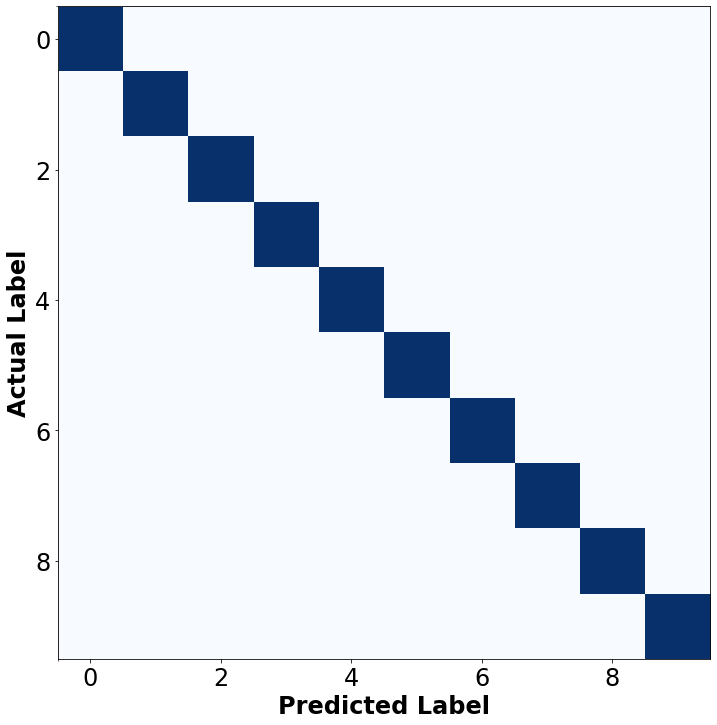

In [13]:
test_predictions = model.predict_classes(test_examples)
train_acc = model.evaluate(train_examples, train_labels, verbose=0)
test_acc = model.evaluate(test_examples, test_labels, verbose=0)
print(test_acc)
tf
con_mat = tf.math.confusion_matrix(
    test_labels,
    test_predictions
).numpy()
plot_cm(con_mat)

Loss and Accuracy During Training

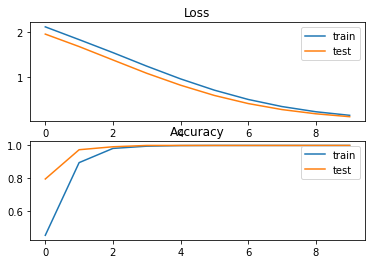

In [14]:
plt.subplot(211)
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
# plot accuracy during training
plt.subplot(212)
plt.title('Accuracy')
plt.plot(history.history['sparse_categorical_accuracy'], label='train')
plt.plot(history.history['val_sparse_categorical_accuracy'], label='test')
plt.legend()
plt.show()

Metrics

In [15]:
accuracy_nn = accuracy_score(test_labels, test_predictions)
print('Accuracy: %f' % accuracy_nn)
precision_nn = precision_score(test_labels, test_predictions,average='micro')
print('Precision: %f' % precision_nn)
# recall: tp / (tp + fn)
recall_nn = recall_score(test_labels, test_predictions,average='micro')
print('Recall: %f' % recall_nn)
# f1: 2 tp / (2 tp + fp + fn)
f1_nn = f1_score(test_labels, test_predictions,average='micro')
print('F1 score: %f' % f1_nn)

# kappa
kappa_nn = cohen_kappa_score(test_labels, test_predictions)
print('Cohens kappa: %f' % kappa_nn)
# ROC AUC
#auc_nn = roc_auc_score(test_labels, test_predictions,multi_class="ovr",average=None)
#print('ROC AUC: %f' % auc_nn)

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000
Cohens kappa: 1.000000


# **SVM/LR**

In [16]:

import sklearn
from sklearn import datasets, svm, metrics

Prepare dataset

In [17]:
x_train = np.reshape(train_examples, (num_keys*train_samples,ifft_length))
y_train = train_labels
x_test = np.reshape(test_examples, (int(num_keys*train_samples/5),ifft_length))
y_test = test_labels

x_train, y_train = sklearn.utils.shuffle(x_train, y_train, random_state=0)
x_test, y_test = sklearn.utils.shuffle(x_test, y_test, random_state=0)

SVM Model

In [18]:
clf = svm.SVC(kernel='linear',gamma='scale')
clf.fit(x_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

1.0


['/content/gdrive/My Drive/Colab Notebooks/SASM/Models/SVM/keys_10_snr_10_range_0.2_exceeta_32_ifft_64_samples_250.joblib']

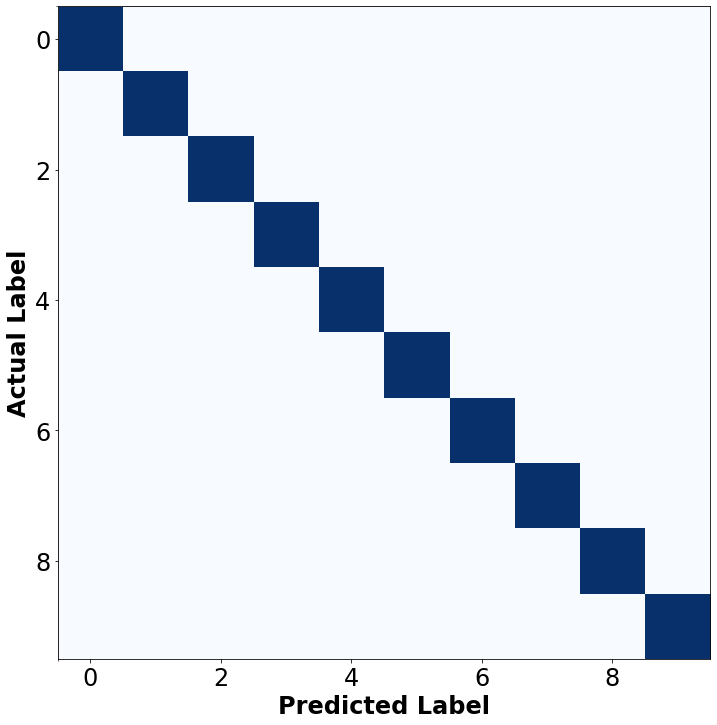

In [19]:
y_pred = clf.predict(x_test)

acc_svm = metrics.accuracy_score(y_test,y_pred)
#test_predictions = model.predict_classes(test_examples)
print(acc_svm)
plot_cm(tf.math.confusion_matrix(y_test, y_pred).numpy())

dump(clf, SVM_model_path)

Metrics

In [20]:
acc_svm = accuracy_score(y_test,y_pred)
print('Accuracy: %f' % acc_svm)
precision_svm = precision_score(y_test,y_pred,average='micro')
print('Precision: %f' % precision_svm)
# recall: tp / (tp + fn)
recall_svm = recall_score(y_test,y_pred,average='micro')
print('Recall: %f' % recall_svm)
# f1: 2 tp / (2 tp + fp + fn)
f1_svm = f1_score(y_test,y_pred,average='micro')
print('F1 score: %f' % f1_svm)

# kappa
kappa_svm = cohen_kappa_score(y_test,y_pred)
print('Kappa score: %f' % kappa_svm)

Accuracy: 1.000000
Precision: 1.000000
Recall: 1.000000
F1 score: 1.000000
Kappa score: 1.000000


LR Model

Accuracy: 1.000000


['/content/gdrive/My Drive/Colab Notebooks/SASM/Models/LR/keys_10_snr_10_range_0.2_exceeta_32_ifft_64_samples_250.joblib']

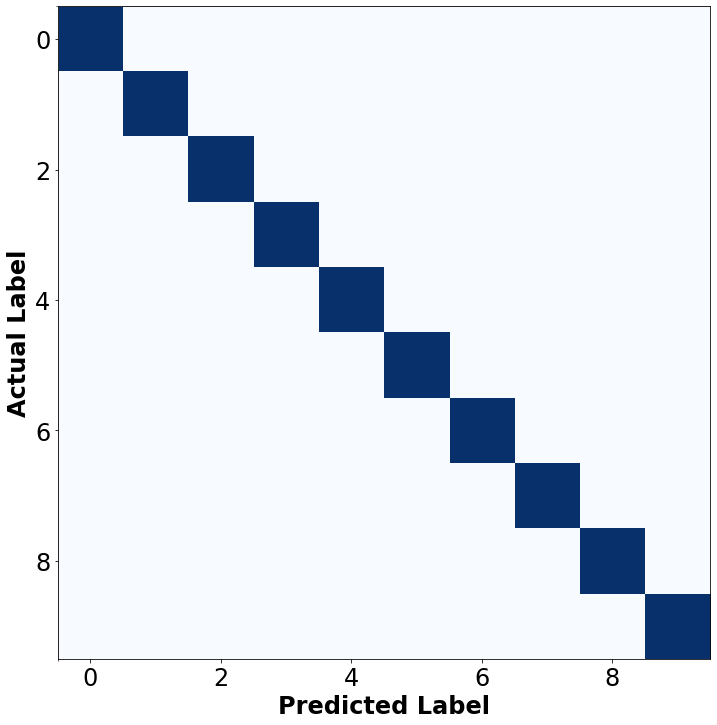

In [21]:

clf_lr = sklearn.linear_model.LogisticRegression(solver='lbfgs',multi_class='auto')
clf_lr.fit(x_train,y_train)
y_pred_lr = clf_lr.predict(x_test)

acc = metrics.accuracy_score(y_test,y_pred_lr)
print('Accuracy: %f' % acc)

plot_cm(tf.math.confusion_matrix(y_test, y_pred_lr).numpy())

dump(clf_lr, LR_model_path)